In [1]:
! pip install snntorch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [2]:
! pip install pytorch-metric-learning --pre


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.4 MB/s eta 0:00:00


In [3]:
! pip install pytorch-metric-learning


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss


In [5]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-5-bd886847109b>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [6]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
#from lightly.loss import NTXentLoss


In [7]:
# dataloader arguments
batch_size = 256
data_path='/data/mnist'


dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
# Define a transform
transform = transforms.Compose([
            #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            #transforms.RandomRotation(degrees=(0, 180)),
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])



In [9]:
mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform )

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 101528732.19it/s]


Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30420817.13it/s]


Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26489345.86it/s]


Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5745032.80it/s]


Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [10]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True )

test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)



In [11]:
train_set_1, train_set_2 = torch.utils.data.random_split(mnist_train, [50000, 10000])


In [12]:
train_1_loader = DataLoader(train_set_1, batch_size=batch_size, shuffle=True, drop_last=True)
train_2_loader = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, drop_last=True)

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


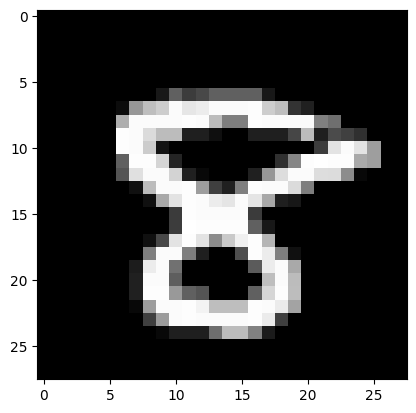

Label: 8


In [13]:
# Display image and label.
train_features, train_labels  = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

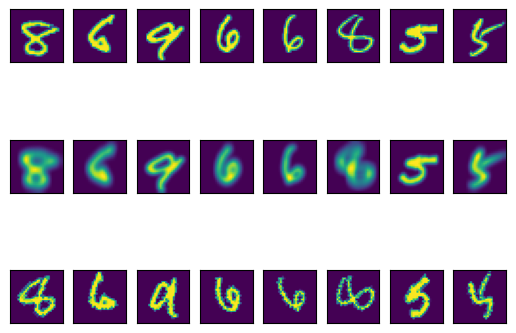

In [14]:
n = 8
fig, ax = plt.subplots(3,n,)
g_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = transforms.RandomRotation(degrees=(30, 45))
for i, img in enumerate(train_features[:n]):
  #plt.imshow(i.squeeze())
  ax[0][i].imshow(img.squeeze())
  ax[1][i].imshow(g_transform(img).squeeze())
  ax[2][i].imshow(r_transform(img).squeeze())
  for j in range(3):
    ax[j][i].get_xaxis().set_visible(False)
    ax[j][i].get_yaxis().set_visible(False)


In [149]:
# neuron and simulation parameters
spike_grad = surrogate.atan()
beta = 0.9
num_steps = 20

In [150]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta , spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta , spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 32)
        self.lif3 = snn.Leaky(beta=beta , spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []

        for step in range(num_steps):
          cur1 = F.max_pool2d(self.conv1(x), 2)
          spk1, mem1 = self.lif1(cur1, mem1)

          cur2 = F.max_pool2d(self.conv2(spk1), 2)
          spk2, mem2 = self.lif2(cur2, mem2)

          cur3 = self.fc1(spk2.view(batch_size, -1))
          spk3, mem3 = self.lif3(cur3, mem3)

          spk_rec.append(spk3)
          mem_rec.append(mem3)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)




In [151]:
net = Net().to(device)

In [152]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spk_out, mem_out = net(data)
spk_out.shape

torch.Size([20, 256, 32])

In [153]:
x = [2,4,6,7,54,9]
#for i in x:
  #plt.plot(spk_out[0][i].detach().numpy())
  #plt.show()

In [154]:
#loss

loss_func_self_trip = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss()
loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(), 
                                    reducer = ThresholdReducer(high=0.3), 
                                    embedding_regularizer = LpRegularizer())

loss_func_self_con = SelfSupervisedLoss(losses.ContrastiveLoss(pos_margin=0, neg_margin=1))

In [155]:
#optimizer

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))


In [156]:

num_epochs = 3
loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    # Training loop
    for data, targets in iter(train_1_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        data_r = r_transform(data)
        data_g = g_transform(data)

        spk_rec_r, mem_rec_r = net(data_r)
        spk_rec_g, mem_rec_g = net(data_g)
        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += loss_func_self_con(mem_rec_r[step], mem_rec_g[step])

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        
        counter += 1
        

0
1
2


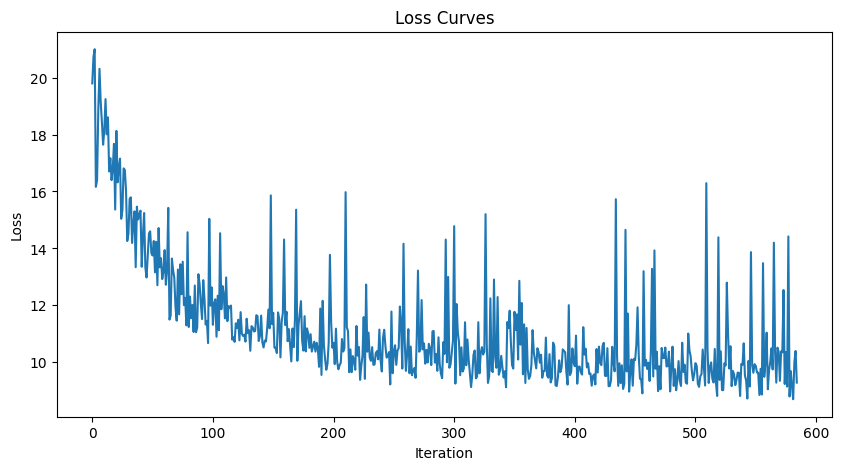

In [157]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.show()


In [158]:
with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(train_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)


In [ ]:
'''x=[0 , 3, 4, 5, 7, 21, 43]
for i in x: 
  plt.plot(mem_rec_r[0][i].detach().numpy())
  plt.show()'''

In [159]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize


In [160]:
n_neighbors=3

num_examples=3

In [161]:

X = test_mem.sum(dim=0).detach().numpy()
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)

distances, indices = nbrs.kneighbors(test_mem.sum(dim=0).detach().numpy())

samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)


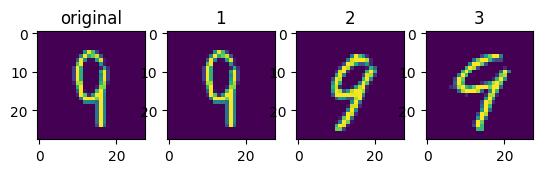

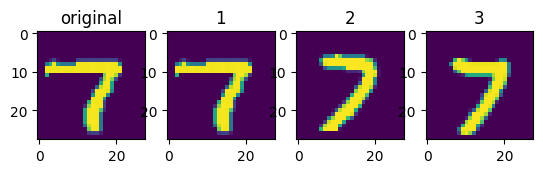

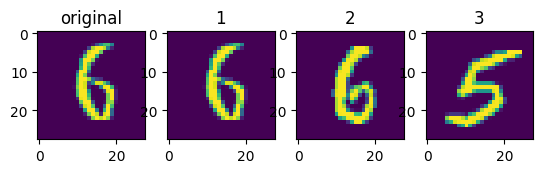

In [162]:
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors+1)
    ax[0].imshow(test_data.squeeze()[samples_idx[i]])
    ax[0].set_title('original')
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j+1].imshow(test_data.squeeze()[k])
      ax[j+1].set_title(j+1)
    

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [164]:
from sklearn.neighbors import KNeighborsClassifier


In [165]:
#Define Network

class Classifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        for param in backbone.parameters():
           param.requires_grad = False

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(32, 10)


    def forward(self, x):
        spk , mem = self.backbone(x)
        y_hat = self.fc(mem)
        return y_hat

# Load the network onto CUDA if available
classifier = Classifier(net).to(device)

In [166]:
classifier

Classifier(
  (backbone): Net(
    (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
    (lif1): Leaky()
    (conv2): Conv2d(12, 64, kernel_size=(5, 5), stride=(1, 1))
    (lif2): Leaky()
    (fc1): Linear(in_features=1024, out_features=32, bias=True)
    (lif3): Leaky()
  )
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [167]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.05, betas=(0.9, 0.999))


In [168]:
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(train_2_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        classifier.train()
        mem_rec = classifier(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += cross_loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            classifier.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_mem = classifier(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += cross_loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            '''# Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''

0
1
2
3
4
5


KeyboardInterrupt: ignored

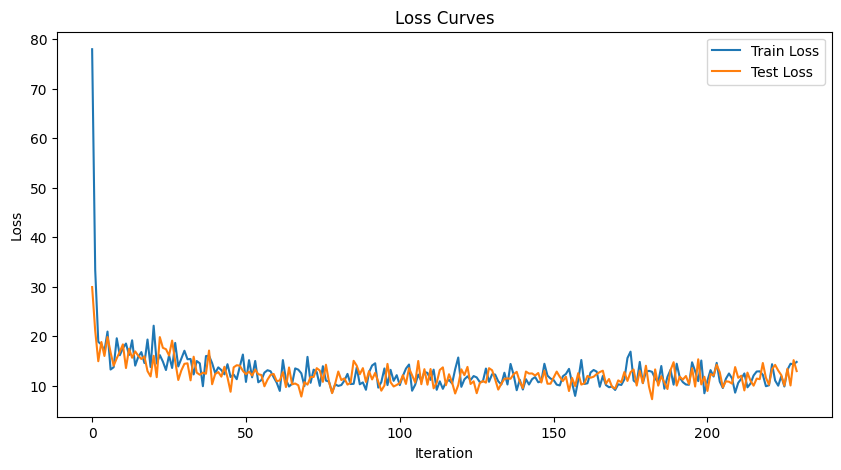

In [169]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [170]:
test_pred=test_mem.sum(dim=0).max(1)[1]


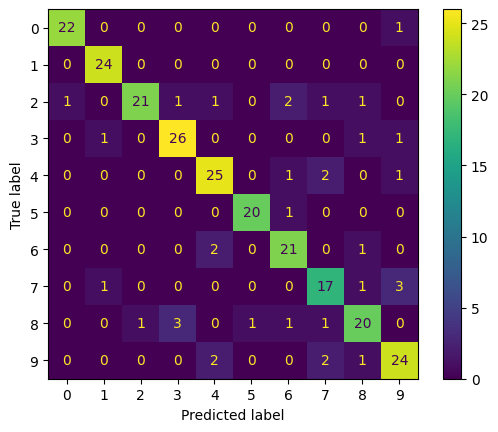

In [171]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets, test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


In [172]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.859375
